# House Price Prediction using regression models with pytorch 

This notebook will show how to predict house price using multi-linear and NN regression with Pytorch

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Pytorch v" + torch.__version__)

%matplotlib inline

Pytorch v2.0.0+cpu


## Step 1: Load and explore the data 

In [2]:
train_data_path = "../input/house-prices-advanced-regression-techniques/train.csv"
train_df = pd.read_csv(train_data_path)

train_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# drop the unnecessary column
train_df = train_df.drop('Id', axis=1)
train_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

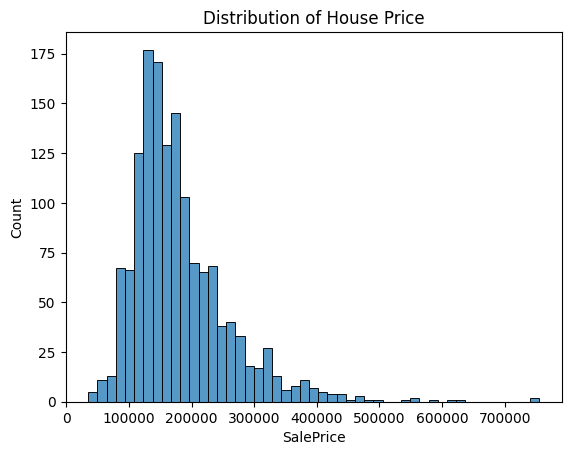

In [5]:
# check the target data
plt.title("Distribution of House Price")
sns.histplot(train_df.SalePrice, kde=False)
train_df['SalePrice'].describe()

## Step 2: Cleaning the dataset 

In [6]:
# check zero and NaN
#print(f"Total number of NaN in the datasets : {train_df.isna().sum()}")
#print(f"Total number of 0 in the datasets : {(train_df == 0.00).sum()}")

num_rows= len(train_df)

# drop the column with more 10% of the null values
train_df.dropna(thresh=num_rows*0.9,axis=1, inplace = True)

# replace any null value with zero (to use all housing data)
train_df.fillna(0, inplace=True)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   object 
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   Utilities      1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

## Step 3: Preprocessing dataset for training a regression model

In [8]:
# find numeric and non-numeric columns

# set target column
output_col = ['SalePrice']

# save the total column names 
total_cols = train_df.columns

# find the input columns
input_cols = list(set(total_cols) - set(output_col))
print(f"total {len(input_cols)} columsn are input for the regression model")
    
# save the column number info
input_size = len(input_cols)
output_size = len(output_col)
    
def convert_to_all_numeric_df(df):
    
    # Make a copy of the original dataframe
    df1 = df.copy(deep=True)
    
    # save the total column names 
    total_cols = df1.columns

    # find categorical columns 
    numeric_cols = df1._get_numeric_data().columns
    categorical_cols = list(set(total_cols) - set(numeric_cols))
    print(f"Among them, {len(categorical_cols)} columns are categorical: {categorical_cols}")

    #convert non-numeric catogerical columns to numeric 
    for col in categorical_cols:
        df1[col] = df1[col].astype('category').cat.codes
    
    # check zero and NaN
    print(f"Total number of NaN in the datasets : {df1.isna().sum()}")
    print(f"Total number of 0 in the datasets : {(df1 == 0.00).sum()}")
    
    return df1
   
    
train_df1 = convert_to_all_numeric_df(train_df)

total 72 columsn are input for the regression model
Among them, 37 columns are categorical: ['CentralAir', 'Exterior2nd', 'Neighborhood', 'Foundation', 'MSZoning', 'SaleCondition', 'GarageType', 'GarageQual', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'Street', 'BsmtFinType1', 'LandContour', 'Electrical', 'PavedDrive', 'Condition1', 'GarageCond', 'SaleType', 'LotConfig', 'LandSlope', 'Functional', 'BldgType', 'KitchenQual', 'Heating', 'BsmtExposure', 'GarageFinish', 'LotShape', 'Utilities', 'ExterQual', 'RoofMatl', 'HeatingQC', 'HouseStyle', 'ExterCond', 'Condition2', 'Exterior1st', 'RoofStyle']
Total number of NaN in the datasets : MSSubClass       0
MSZoning         0
LotArea          0
Street           0
LotShape         0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 73, dtype: int64
Total number of 0 in the datasets : MSSubClass         0
MSZoning          10
LotArea            0
Street             6
LotShape

In [9]:
# As preprocessing, the target value, SalePrice will be converted to Million unit. 
train_df1[output_col] = train_df1[output_col]/1.e6

# Create input and output data
X = train_df1[input_cols].to_numpy()
y = train_df1[output_col].to_numpy()

# split the train/validation and test data
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

#split train into train and validation dtat
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=20)


In [10]:
class CustomMinMaxScaler: 
    
    # This scaler can allow the validation or test data to have values outside of the train min/max range
    # If the test range goes below 0 or above 1, it clips them to 0 or 1.  
        
    def __init__(self, lower_bound =0.2, upper_bound =0.9, limit_range = (0,1)):
        self.min_ = None
        self.range_ = None
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.limit_min, self.limit_max = limit_range
        
    def fit(self, X):
        data_min = np.min(X, axis=0)
        data_max = np.min(X, axis=0)
        
        scale = self.upper_bound - self.lower_bound
        data_range = data_max - data_min
        
        data_range [ data_range == 0] = 1
        
        self.min_ = data_min
        self.range_ = scale / data_range 

        
    def transform(self, X):
        scaled_X  = self.lower_bound + (X - self.min_) * self.range_
        return np.clip(scaled_X, self.limit_min, self.limit_max)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
    def inverse_transform(self,X):
        clipped_X = np.clip(scaled_X, self.limit_min, self.limit_max)
        return (clipped_X - self.lower_bound) / self.range_ + self.min_
    
    

# scale the input data
#input_scaler = CustomMinMaxScaler()
input_scaler = preprocessing.StandardScaler()

# preprocessing input using built-in Scaler 
X_train = input_scaler.fit_transform(X_train)
X_val = input_scaler.transform(X_val)
X_test = input_scaler.transform(X_test)


## Step 4: Initialize data for Pytorch

In [11]:
def numpy_to_dataset (X, y):
    
    # Create PyTorch Tensors from Numpy arrays
    inputs = torch.from_numpy(X).float()
    targets = torch.from_numpy(y).float()

    # create Train PyTorch dataset 
    torch_dataset = TensorDataset(inputs, targets)
    return torch_dataset

# initialize datasets
train_ds = numpy_to_dataset(X_train, y_train)
val_ds = numpy_to_dataset(X_val, y_val)
test_ds = numpy_to_dataset(X_test, y_test)


In [12]:
# Initialize dataloaders 
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size, shuffle=True)

for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[ 0.2580, -0.6885,  0.8379,  ..., -0.2417, -6.3564, -0.5294],
        [ 0.2580, -1.2608,  0.7643,  ..., -0.2417, -0.0387, -1.1623],
        [ 0.2580, -1.2608,  0.9240,  ..., -0.2417, -0.0387, -1.1623],
        ...,
        [ 0.2580,  0.7421, -0.9496,  ..., -0.2417, -0.0387,  0.7363],
        [ 0.2580,  0.7421,  3.0495,  ..., -0.2417, -0.0387,  0.7363],
        [ 0.2580,  0.7421, -0.9496,  ...,  3.9592, -0.0387,  0.7363]])
targets: tensor([[0.1180],
        [0.1185],
        [0.1400],
        [0.1710],
        [0.0795],
        [0.1110],
        [0.2625],
        [0.1190],
        [0.1449],
        [0.2670],
        [0.1375],
        [0.2750],
        [0.3785],
        [0.2800],
        [0.1369],
        [0.1600],
        [0.2641],
        [0.1400],
        [0.1535],
        [0.1440],
        [0.2100],
        [0.1150],
        [0.1672],
        [0.1180],
        [0.3673],
        [0.1280],
        [0.1875],
        [0.6117],
        [0.1450],
        [0.1320],
        [

## Step 5 : Create Model Architecture

In [13]:
class MultiLinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiLinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        out = self.linear(x)
        return out

class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim=36):
        super(SimpleNN, self).__init__()
        
        mid_hidden_dim = hidden_dim // 2
        
        self.fc1  = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, mid_hidden_dim)
        # self.fc3 = nn.Linear(mid_hidden_dim, mid_hidden_dim)
        self.fc3 = nn.Linear(mid_hidden_dim, output_size)
        
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        # x = self.activation(self.fc3(x))  adding layer doesn't improve the prediction
        x = self.fc3(x)
        return x

In [14]:
MLR_model = MultiLinearRegression(input_size, output_size)
model = SimpleNN(input_size, output_size)
#list(model.parameters())

## Step 6: Train the model 

In [15]:
def train_model(model, train_loader, val_loader, epochs, lr, opt_func=torch.optim.Adam):
    criterian = nn.MSELoss()
    optimizer = opt_func(model.parameters(), lr)
    
    # Lists to store the epoch-wise losses
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            
            y_pred = model(X_batch)
            
            loss = criterian(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
            
        model.eval()
        
        val_loss = 0.
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterian(y_pred, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} => "
              f"Train loss: {train_loss:.4f}, "
              f"Validation loss: {val_loss:.4f}")
        
    return train_losses, val_losses

In [16]:
def train_two_models(main_model, special_model, train_loader, val_loader, epochs, lr, opt_func=torch.optim.Adam):
    
    criterian = nn.MSELoss()
    optimizer_main = opt_func(model.parameters(), lr)
    optimizer_special = opt_func(special_model.parameters(), lr)
    
    # Lists to store the epoch-wise losses
    train_losses = []
    val_losses = []
    
    
    
    for epoch in range(epochs):
        main_model.train()
        special_model.train()
        train_loss = 0.
        
        for X_batch, y_batch in train_loader:
            optimizer_main.zero_grad()
            
            y_pred_main = main_model(X_batch)
            
            loss_main = criterian(y_pred_main, y_batch)
            loss_main.backward()
            optimizer_main.step()
            
            # if the main prediction isn't satified, try the special model
            errors = y_batch - y_pred_main 
            threshold = torch.quantile(torch.abs(errors), 0.7)  
            rerun_indices = torch.where(torch.abs(errors) > threshold)[0]
            
            if len(rerun_indices) > 0:
                X_special, y_special = X_batch[rerun_indices], y_batch[rerun_indices]
                optimizer_special.zero_grad()
                y_pred_special = special_model(X_special)
                loss_special = criterian(y_pred_special, y_special)
                loss_special.backward()
                optimizer_special.step()
            
            train_loss += loss_main.item() * X_batch.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
            
        main_model.eval()
        special_model.eval()
        val_loss = 0.
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred_main = main_model(X_batch)
                
                # if the main prediction isn't satified, try the special model
                errors = y_batch - y_pred_main 
                threshold = torch.quantile(torch.abs(errors), 0.7)  
                rerun_indices = torch.where(torch.abs(errors) > threshold)[0]
            
                if len(rerun_indices) > 0:
                    X_special, y_special = X_batch[rerun_indices], y_batch[rerun_indices]
                    y_pred_special = special_model(X_special)
                    y_pred_main[rerun_indices] = y_pred_special
    
                
                loss = criterian(y_pred_main, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} => "
              f"Train loss: {train_loss:.4f}, "
              f"Validation loss: {val_loss:.4f}")
        
    return train_losses, val_losses

In [17]:
epochs = 100
lr = 1e-3
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs, lr)

Epoch 1/100 => Train loss: 0.0726, Validation loss: 0.0257
Epoch 2/100 => Train loss: 0.0142, Validation loss: 0.0103
Epoch 3/100 => Train loss: 0.0088, Validation loss: 0.0075
Epoch 4/100 => Train loss: 0.0049, Validation loss: 0.0065
Epoch 5/100 => Train loss: 0.0040, Validation loss: 0.0057
Epoch 6/100 => Train loss: 0.0030, Validation loss: 0.0049
Epoch 7/100 => Train loss: 0.0025, Validation loss: 0.0044
Epoch 8/100 => Train loss: 0.0021, Validation loss: 0.0040
Epoch 9/100 => Train loss: 0.0019, Validation loss: 0.0038
Epoch 10/100 => Train loss: 0.0017, Validation loss: 0.0036
Epoch 11/100 => Train loss: 0.0015, Validation loss: 0.0034
Epoch 12/100 => Train loss: 0.0013, Validation loss: 0.0032
Epoch 13/100 => Train loss: 0.0012, Validation loss: 0.0031
Epoch 14/100 => Train loss: 0.0011, Validation loss: 0.0030
Epoch 15/100 => Train loss: 0.0011, Validation loss: 0.0030
Epoch 16/100 => Train loss: 0.0010, Validation loss: 0.0029
Epoch 17/100 => Train loss: 0.0009, Validation lo

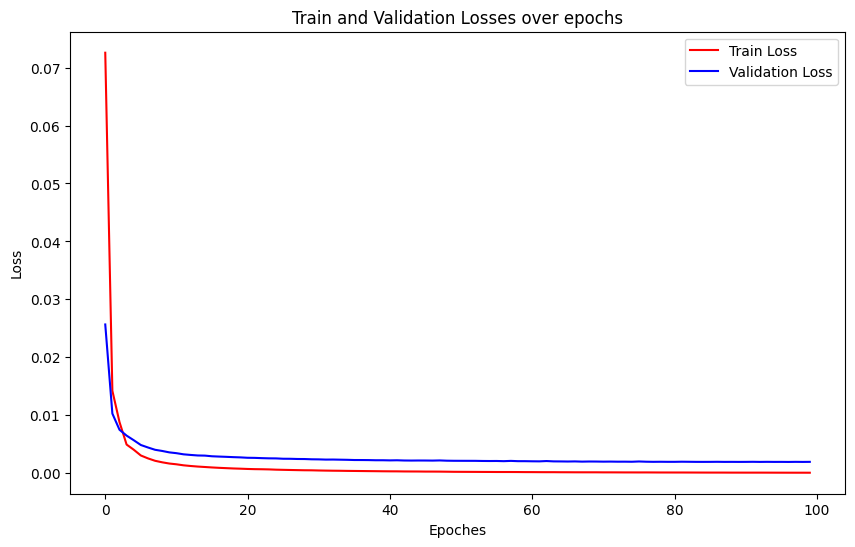

In [18]:
# plot the losses
plt.figure(figsize = (10,6))

plt.plot(range(epochs), train_losses, label = 'Train Loss', color = 'red')
plt.plot(range(epochs), val_losses, label = 'Validation Loss', color = 'blue')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.title('Train and Validation Losses over epochs')
plt.legend()
plt.show()

## Step 7: Test the trained model 

In [19]:
def test_model(model, test_loader):
    criterian = nn.MSELoss()
    model.eval()
    test_loss = 0
    
    predicted = []
    actual = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterian(y_pred, y_batch)
            test_loss += loss.item() * X_batch.size(0)
            
            # save each predictions and actual_value for comparisons
            predicted.extend(y_pred.squeeze().tolist())
            actual.extend(y_batch.squeeze().tolist())
            
    test_loss /= len(test_loader.dataset)
    print(f"Test loss: {test_loss:.4f}")

    return predicted, actual

In [20]:
predictions, actual_values = test_model(model, test_loader)

for i in range(10):
    print(f"Prediction: {predictions[i]:.4f}, Actual_value: {actual_values[i]:.4f}")

# convert the price from million $ to $
predictions = [x * 1.e6 for x in predictions] 
actual_values = [x * 1.e6 for x in actual_values] 

log_predicted = np.log1p(np.array(predictions))
log_actual = np.log1p(np.array(actual_values))

# Calculate key statistics
MSE = np.mean((log_predicted - log_actual)**2 )
RMSE = np.sqrt(MSE)
R  = np.corrcoef(predictions, actual_values)[0,1]

stats_text = f'MSE: {MSE:.4f}\nRMSE: {RMSE:.4f}\nCorrelation Coefficient: {R:.4f}'
print(stats_text)

Test loss: 0.0030
Prediction: 0.1280, Actual_value: 0.1200
Prediction: 0.2057, Actual_value: 0.1750
Prediction: 0.1305, Actual_value: 0.1402
Prediction: 0.2274, Actual_value: 0.1985
Prediction: 0.1051, Actual_value: 0.1100
Prediction: 0.1325, Actual_value: 0.1220
Prediction: 0.5606, Actual_value: 0.4388
Prediction: 0.0803, Actual_value: 0.1320
Prediction: 0.2412, Actual_value: 0.1930
Prediction: 0.1992, Actual_value: 0.1590
MSE: nan
RMSE: nan
Correlation Coefficient: 0.7800


/tmp/ipykernel_21/2494118559.py:10: RuntimeWarning: invalid value encountered in log1p
  log_predicted = np.log1p(np.array(predictions))


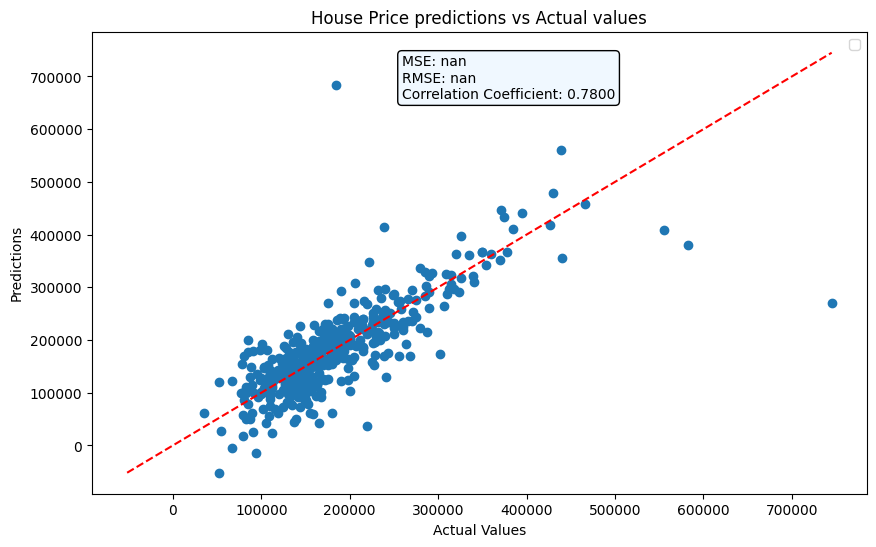

In [21]:
# plot the predictions and actual_values
plt.figure(figsize = (10,6))

plt.scatter(actual_values,  predictions)
# Add the 1:1 line
min_val = min(min(actual_values), min(predictions))
max_val = max(max(actual_values), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')


# Adding the key statistics on the plot
plt.text(0.4, 0.95, stats_text, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="aliceblue"))
    
    
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('House Price predictions vs Actual values')
plt.legend()
plt.show()

# Final : Submission

In [22]:
test_file = '../input/house-prices-advanced-regression-techniques/test.csv'
test_df = pd.read_csv(test_file)

print(test_df.shape)

# placeholder for output column
test_df['SalePrice'] = 0.

test_df.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,0.0
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,0.0
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,0.0
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,0.0
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,0.0


In [23]:
# apply the same cleaning/preprocessing methods to the test data

# first, save id columns for output
test_ids = test_df.pop('Id')

# remove the columns unused
test_df = pd.concat([test_df[input_cols], test_df[output_col]], axis =1) 

# replace any null values with zero 
test_df.fillna(0, inplace = True)

# convert all columns to numerical df
test_df1 = convert_to_all_numeric_df(test_df)

# Create input and output data
X = test_df1[input_cols].to_numpy()
y = test_df1[output_col].to_numpy()

# preprocessing input using built-in Scaler 
X_scaled = input_scaler.transform(X)

#Initialize dataset and dataloaders 
sample_ds = numpy_to_dataset(X_scaled, y)
batch_size = 60
sample_loader = DataLoader(sample_ds, batch_size, shuffle=False)


Among them, 37 columns are categorical: ['CentralAir', 'Exterior2nd', 'Neighborhood', 'Foundation', 'MSZoning', 'SaleCondition', 'GarageType', 'GarageQual', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'Street', 'BsmtFinType1', 'Electrical', 'LandContour', 'PavedDrive', 'Condition1', 'GarageCond', 'SaleType', 'LotConfig', 'LandSlope', 'Functional', 'BldgType', 'KitchenQual', 'Heating', 'BsmtExposure', 'GarageFinish', 'LotShape', 'Utilities', 'ExterQual', 'RoofMatl', 'HeatingQC', 'HouseStyle', 'ExterCond', 'Condition2', 'Exterior1st', 'RoofStyle']
Total number of NaN in the datasets : CentralAir      0
Exterior2nd     0
BsmtFinSF1      0
LowQualFinSF    0
Fireplaces      0
               ..
ExterCond       0
BsmtHalfBath    0
Condition2      0
Exterior1st     0
SalePrice       0
Length: 73, dtype: int64
Total number of 0 in the datasets : CentralAir       101
Exterior2nd        1
BsmtFinSF1       463
LowQualFinSF    1445
Fireplaces       730
                ... 
ExterCond          9
BsmtHalf

In [24]:
def predict_model(model, sample_loader):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for X_batch, y_batch in sample_loader:
            y_pred = model(X_batch)
            predictions.extend(y_pred.squeeze().tolist())

    return predictions

house_price_predictions = predict_model(model, sample_loader)

# save the output
output = pd.DataFrame( {'Id': test_ids,
                       'SalePrice': house_price_predictions })

output.head()


,Id,SalePrice
0,1461,0.183425
1,1462,0.446016
2,1463,0.241656
3,1464,0.253827
4,1465,0.235545


In [25]:
submit_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
submit_df['SalePrice'] = house_price_predictions  

# convert the price back to $ from million $
submit_df['SalePrice'] = submit_df['SalePrice'].apply(lambda x:x*1.e6) 

submit_df.to_csv('/kaggle/working/submission.csv',index=False)
submit_df.head()

,Id,SalePrice
0,1461,183425.068855
1,1462,446016.192436
2,1463,241656.243801
3,1464,253826.528788
4,1465,235544.502735
